## <a>**Import**</a>
Import all required libraries for model building, data augmentation, and visualization.  
This includes libraries like TensorFlow, NumPy, Seaborn, Matplotlib, and others.

In [ ]:
import os, time
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, ResNet152V2, InceptionV3, InceptionResNetV2, Xception, MobileNetV2, MobileNetV3Large, DenseNet121, DenseNet201, EfficientNetV2B2, NASNetMobile
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns


## <a>**Constants**</a>
Define constants for directory paths, image size, number of classes, epochs, learning rate, and batch size.  
These values ensure uniformity and control in training the models.


In [ ]:
root = os.path.dirname(os.path.dirname(os.getcwd()))

train_dir = os.path.join(root, 'data', 'current', 'train')

IMAGE_DIM = 150
NB_CLASS = 3
NB_EPOCH = 7
L_RATE = 0.001
BATCH = 64

c:\Users\tgoor\Documents\Python Scripts\medical CV


## <a>**Data augmentation**</a>
Apply data augmentation to training and validation data to increase model robustness.  
Augmentations include zoom, rotation, shear, and flips to simulate real-world variations.


In [125]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,             # Zoom
    rotation_range=20,          # Rotation des images
    width_shift_range=0.001,      # Translation horizontale
    height_shift_range=0.001,     # Translation verticale
    shear_range=0.01,            # Transformation affine
    horizontal_flip=True,       # Symétrie horizontale
    fill_mode='nearest',        # Remplir les zones vides après transformation
    validation_split=0.2        # Division en validation
)

train_data = datagen_train.flow_from_directory(
    train_dir,
    seed = 42,
    color_mode = 'rgb',
    target_size=(IMAGE_DIM, IMAGE_DIM), 
    batch_size=BATCH,
    class_mode='categorical',      
    subset='training'
)

val_data = datagen_train.flow_from_directory(
    train_dir,
    seed = 42,
    color_mode = 'rgb',
    target_size=(IMAGE_DIM, IMAGE_DIM),
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)



Found 1080 images belonging to 3 classes.
Found 269 images belonging to 3 classes.


## <a>**Build models**</a>
Build and compile deep learning models using transfer learning.  
Freeze the pre-trained base layers and add custom layers (Dense, Dropout) for specific tasks.  
Models are trained, evaluated, and saved.



In [110]:

def model_builder (model, name = str(time.time()), epoch = NB_EPOCH, lr = L_RATE):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # -- compile --
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(model.summary())
    class_weights = dict(enumerate(compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_data.classes),
        y=train_data.classes
    )))
    # -- train --
    # Use checkpoints
    checkpoint_path =  os.path.join(root, 'model', 'checkpoints', 'cp.weights.h5')
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=1
    )
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epoch,
        callbacks=[cp_callback, lr_callback, early_stopping],
        # steps_per_epoch=train_steps,
        # validation_steps=val_steps,
        class_weight=class_weights
    )
    # -- save --
    save_path =  os.path.join(root, 'model', 'model_' + name + '.h5')
    model.save(save_path)
    # -- Evaluate --
    test_loss, test_acc = model.evaluate(val_data)
    print(f"Test Accuracy: {test_acc*100:.2f}%")

    # Prédictions sur le set de test
    predictions = model.predict(val_data)
    predicted_classes = predictions.argmax(axis=1)
    print("Predictions done.")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/7


c:\Users\tgoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4656 - loss: 1.6054
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.4726 - loss: 1.5791 - val_accuracy: 0.8290 - val_loss: 0.4591 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7885 - loss: 0.4330
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.7909 - loss: 0.4295 - val_accuracy: 0.8773 - val_loss: 0.3206 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8982 - loss: 0.2566
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.8989 - loss: 0.2564 - val_accuracy: 0.9257 - val_loss: 0.2134 - learning_rate: 0.0010
Epoch 4/7
17/17 ━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9709 - loss: 0.1248
Test Accuracy: 96.28%
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step
Predictions done.


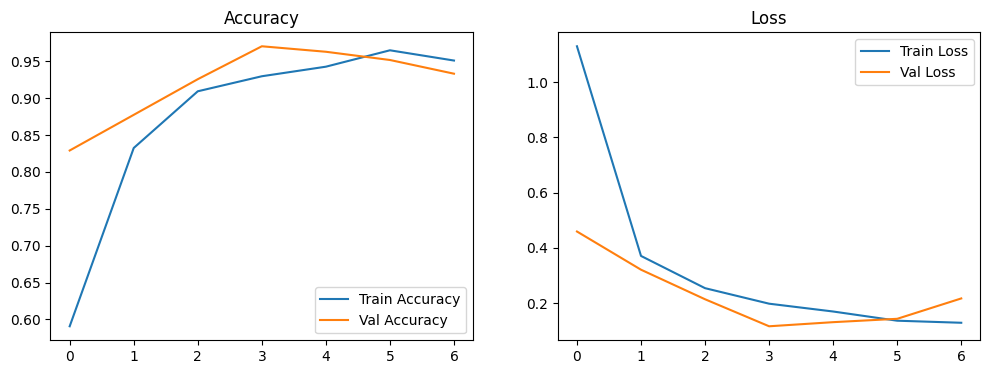

In [111]:
#---- VGG16 ----
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'VGG16')


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

None
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3241 - loss: 3.7230
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.3253 - loss: 3.6642 - val_accuracy: 0.6022 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4530 - loss: 1.1159
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4508 - loss: 1.1110 - val_accuracy: 0.3903 - val_loss: 1.0439 - learning_rate: 0.0010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3774 - loss: 0.9486
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3786 - loss: 0.9477 - val_accuracy: 0.4796 - val_loss: 0.9617 - learning_rate: 0.0010
Epoch

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5854 - loss: 0.9299
Test Accuracy: 60.59%
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Predictions done.


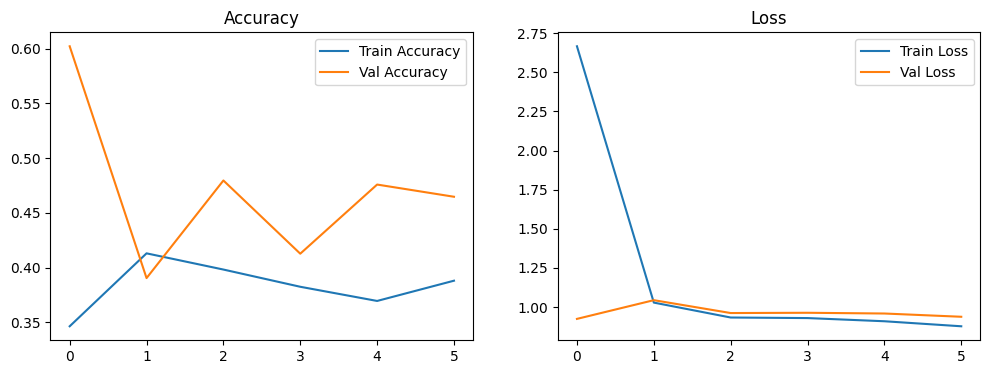

In [112]:
#---- ResNet50 ----
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# ResNet50
model_builder(model,'ResNet50', epoch= 10)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4683 - loss: 2.1128
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - accuracy: 0.4759 - loss: 2.0759 - val_accuracy: 0.9071 - val_loss: 0.3275 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8555 - loss: 0.4389
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.8553 - loss: 0.4388 - val_accuracy: 0.8959 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8828 - loss: 0.2822
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.8828 - loss: 0.2829 - val_accuracy: 0.8662 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 4

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9587 - loss: 0.1100
Test Accuracy: 95.17%
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
Predictions done.


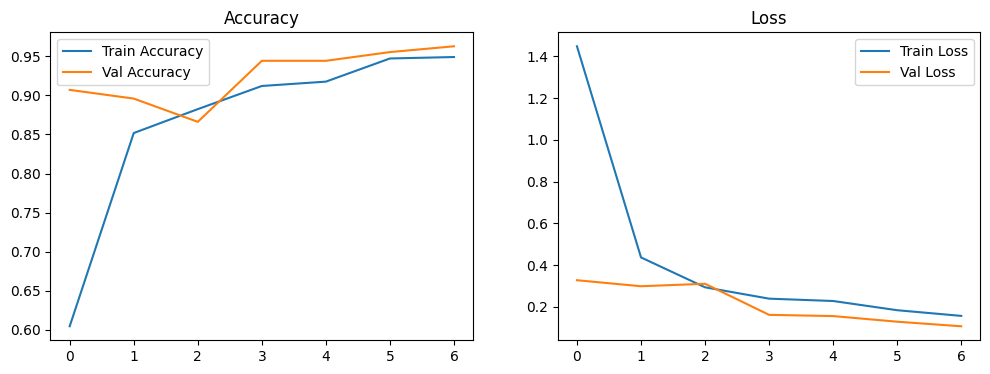

In [113]:
#---- VGG19 ----
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'VGG19')

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ ?                      │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,331,648 (222.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 58,331,648 (222.52 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6185 - loss: 17.9017
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - accuracy: 0.6227 - loss: 17.4238 - val_accuracy: 0.8848 - val_loss: 0.3368 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8320 - loss: 0.6738
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 94s 5s/step - accuracy: 0.8326 - loss: 0.6640 - val_accuracy: 0.9442 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8791 - loss: 0.3421
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.8788 - loss: 0.3418 - val_accuracy: 0.9331 - val_loss: 0.1760 - learning_rate: 0.0010
Epoch

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9624 - loss: 0.0912
Test Accuracy: 96.28%
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step
Predictions done.


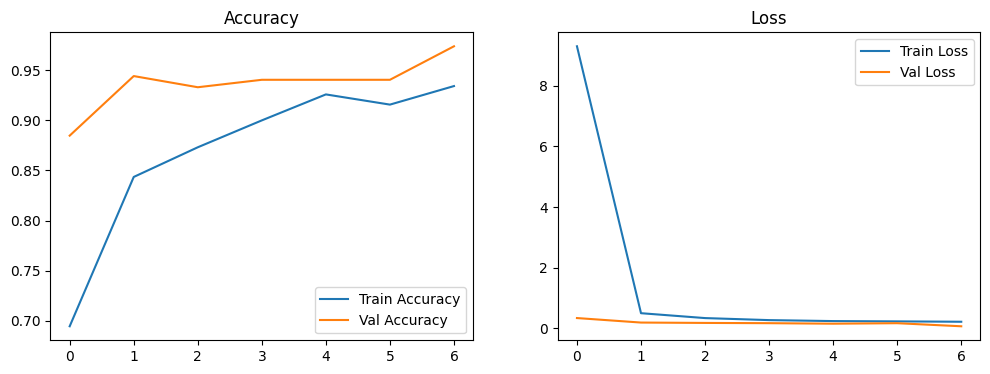

In [114]:
#---- ResNet152V2 ----
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'ResNet152V2')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.4621 - loss: 17.2302
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4665 - loss: 17.0086 - val_accuracy: 0.7026 - val_loss: 3.1898 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.7574 - loss: 3.1161
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7570 - loss: 3.0748 - val_accuracy: 0.8810 - val_loss: 0.3384 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8350 - loss: 0.5594
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8347 - loss: 0.5556 - val_accuracy: 0.8699 - val_loss: 0.3033 - learning_rate: 0.00

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9170 - loss: 0.2260
Test Accuracy: 91.82%
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Predictions done.


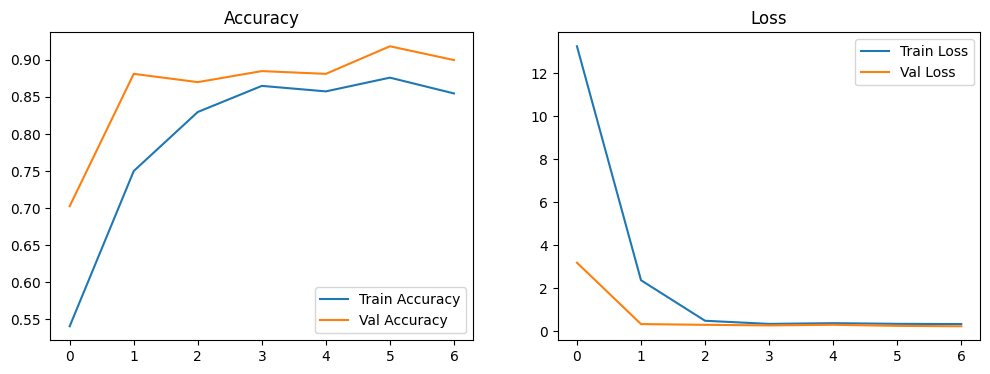

In [115]:
#---- InceptionV3 ----
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'InceptionV3')

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ ?                      │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4692 - loss: 15.9223
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.4735 - loss: 15.7515 - val_accuracy: 0.8327 - val_loss: 1.6086 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7363 - loss: 3.2427
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7370 - loss: 3.1754 - val_accuracy: 0.8439 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7224 - loss: 0.6352
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7232 - loss: 0.6331 - val_accuracy: 0.8625 - val_loss: 0.3707 - learning_rate: 0.0010
Epoch 

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9034 - loss: 0.2445
Test Accuracy: 89.96%
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step
Predictions done.


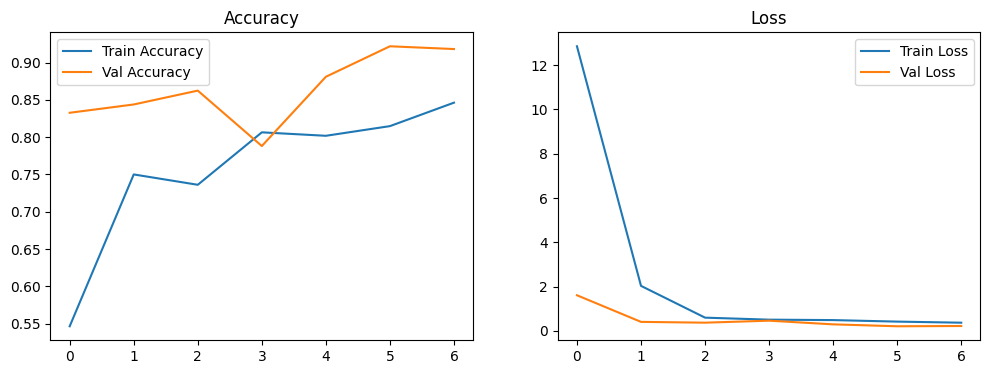

In [116]:
#---- InceptionResNetV2 ----
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'InceptionResNetV2')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6056 - loss: 7.6282
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6123 - loss: 7.5407 - val_accuracy: 0.6729 - val_loss: 3.3709 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7532 - loss: 2.6779
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7560 - loss: 2.6336 - val_accuracy: 0.8885 - val_loss: 0.5396 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8740 - loss: 0.6257
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8734 - loss: 0.6212 - val_accuracy: 0.9257 - val_loss: 0.1941 - learning_rate: 0.0010
Epoch 4/

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9645 - loss: 0.1279
Test Accuracy: 96.65%
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Predictions done.


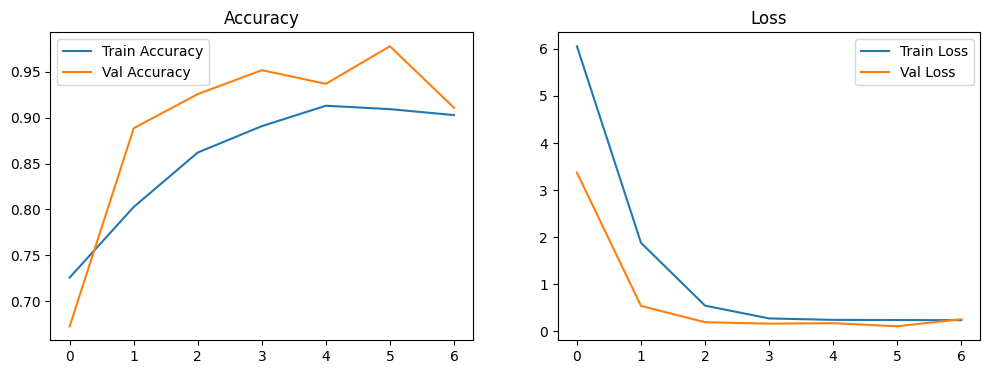

In [117]:
#---- Xception ----
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'Xception')

C:\Users\tgoor\AppData\Local\Temp\ipykernel_26688\1129619433.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4759 - loss: 15.4155
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4831 - loss: 15.2502 - val_accuracy: 0.8773 - val_loss: 1.6554 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.8241 - loss: 2.6749
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8245 - loss: 2.6396 - val_accuracy: 0.9331 - val_loss: 0.3251 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9030 - loss: 0.5437
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9020 - loss: 0.5335 - val_accuracy: 0.9294 - val_loss: 0.1801 - learning_rate: 0.0010
Epo

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 992ms/step - accuracy: 0.9538 - loss: 0.1177
Test Accuracy: 94.80%
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step 
Predictions done.


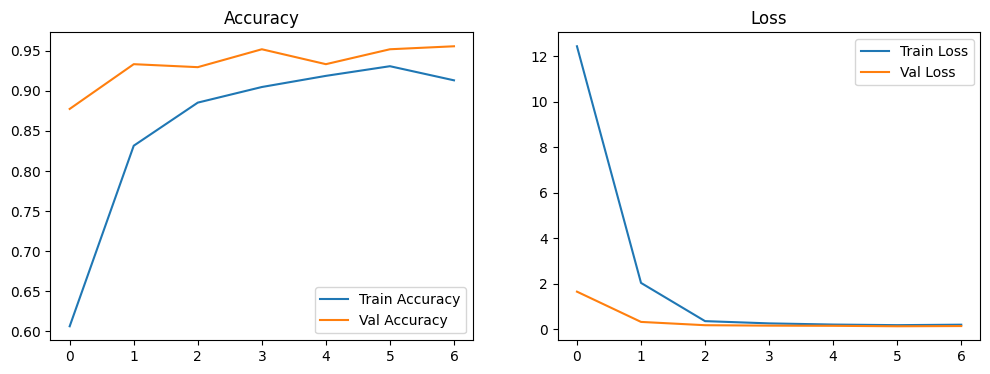

In [118]:
#---- MobileNetV2 ----
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'MobileNetV2')

c:\Users\tgoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\applications\mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)   │ ?                      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.4003 - loss: 4.5152
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4020 - loss: 4.4312 - val_accuracy: 0.6283 - val_loss: 0.9646 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.5326 - loss: 0.9219
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5355 - loss: 0.9211 - val_accuracy: 0.6952 - val_loss: 0.9022 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.6031 - loss: 0.8210
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6027 - loss: 0.8218 - val_accuracy: 0.7138 - val_loss: 0.8216 - learning_rate: 0.0010

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 987ms/step - accuracy: 0.7691 - loss: 0.6579
Test Accuracy: 75.84%
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step 
Predictions done.


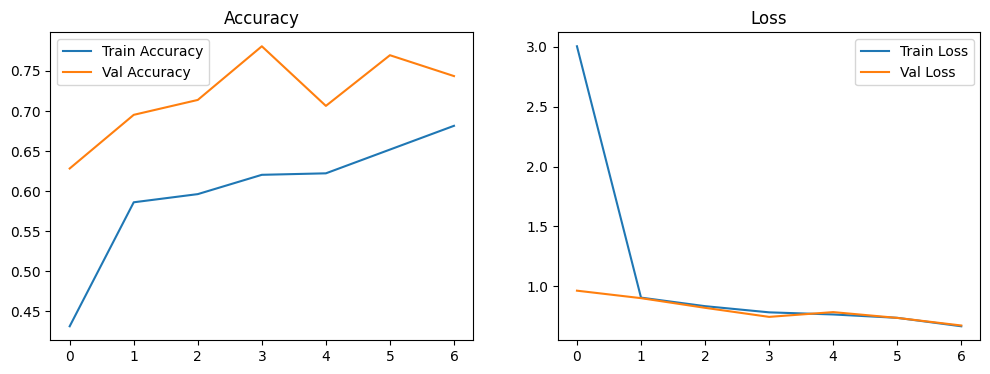

In [119]:
#---- MobileNetV3Large ----
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'MobileNetV3Large')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4232 - loss: 15.0837
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.4301 - loss: 14.8317 - val_accuracy: 0.6952 - val_loss: 2.0826 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7387 - loss: 1.9812
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7397 - loss: 1.9464 - val_accuracy: 0.7732 - val_loss: 0.6326 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8022 - loss: 0.5015
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8045 - loss: 0.4983 - val_accuracy: 0.8364 - val_loss: 0.4379 - learning_rate: 0.0010
Epoch 

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9452 - loss: 0.1347
Test Accuracy: 94.42%
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Predictions done.


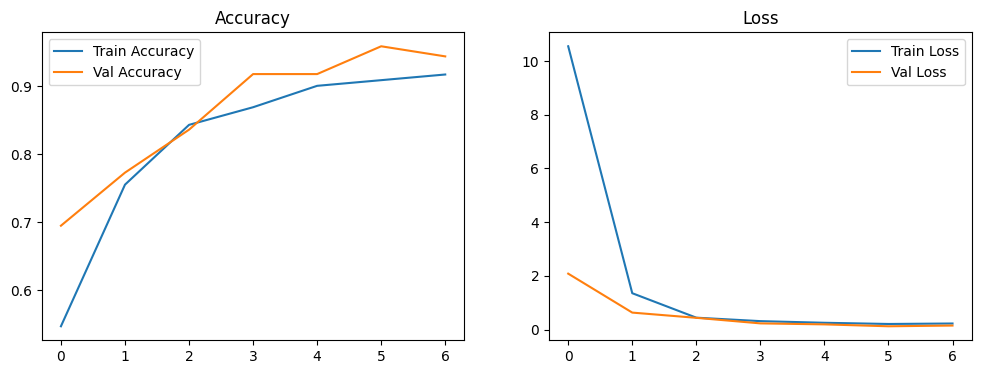

In [120]:
#---- DenseNet121 ----
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'DenseNet121')

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5480 - loss: 8.3584
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5537 - loss: 8.2462 - val_accuracy: 0.8141 - val_loss: 2.3435 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8561 - loss: 1.9627
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8566 - loss: 1.9408 - val_accuracy: 0.9331 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9330 - loss: 0.5114
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9327 - loss: 0.5060 - val_accuracy: 0.9628 - val_loss: 0.1946 - learning_rate: 0.0010
Epoch 4/

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9679 - loss: 0.0802
Test Accuracy: 96.28%
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
Predictions done.


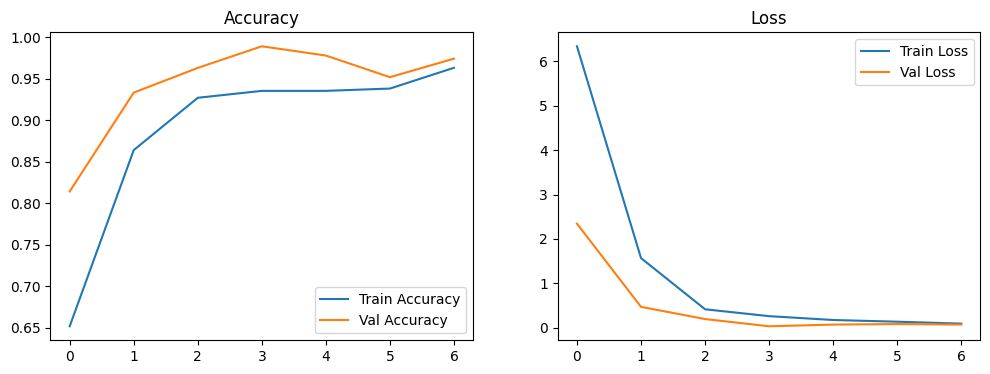

In [121]:
#---- DenseNet201 ----
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'DenseNet201')

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b2 (Functional)  │ ?                      │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 8,769,374 (33.45 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3329 - loss: 11.4560
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3325 - loss: 11.2844 - val_accuracy: 0.2416 - val_loss: 1.3059 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2748 - loss: 1.5486
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.2784 - loss: 1.5344 - val_accuracy: 0.6022 - val_loss: 1.0983 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5932 - loss: 1.1027
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5935 - loss: 1.1025 - val_accuracy: 0.6022 - val_loss: 1.0982 - learning_rate: 0.0010
Epoch 

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6198 - loss: 1.0982
Test Accuracy: 60.22%
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Predictions done.


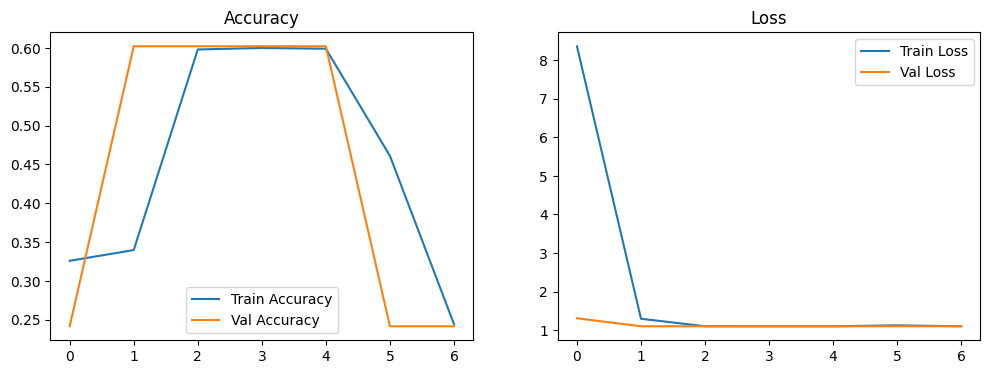

In [122]:
#---- EfficientNetV2B2 ----
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'EfficientNetV2B2')

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NASNet (Functional)             │ ?                      │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,269,716 (16.29 MB)

None
Epoch 1/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.4888 - loss: 10.8378
Epoch 1: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4951 - loss: 10.7217 - val_accuracy: 0.6877 - val_loss: 3.4954 - learning_rate: 0.0010
Epoch 2/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.7032 - loss: 2.4157
Epoch 2: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7068 - loss: 2.3803 - val_accuracy: 0.7621 - val_loss: 1.1901 - learning_rate: 0.0010
Epoch 3/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.7807 - loss: 0.8329
Epoch 3: saving model to c:\Users\tgoor\Documents\Python Scripts\medical CV\model\checkpoints\cp.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7813 - loss: 0.8237 - val_accuracy: 0.8922 - val_loss: 0.3863 - learning_rate: 0.00

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 997ms/step - accuracy: 0.9463 - loss: 0.2068
Test Accuracy: 95.17%
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Predictions done.


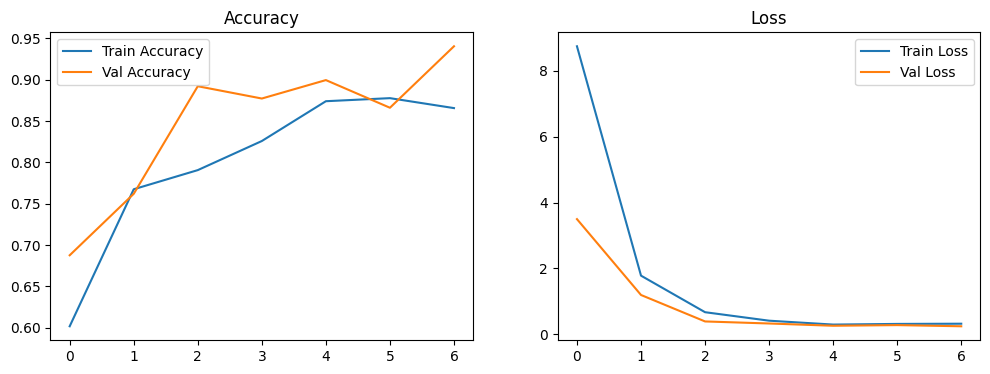

In [123]:
#---- NASNetMobile ----
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMAGE_DIM,IMAGE_DIM,3))
# Freeze les couches de base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# VGG16
model_builder(model,'NASNetMobile')